In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing as skp 
import utils as ut
import netutils as net

In [2]:
# Let us read the logs into the various files 
# For each log, we will map source and destinations IP to local IPV4 format. 
# To do this, we define a new routine that uses the mapping_dict stored to do the mappings and read files. 

mapping_dict=ut.read_as_dict('unsw/mapping.csv','Original','Mapped')
conn_df = net.read_n_map('unsw/day_logs/conn.log', mapping_dict)
http_df = net.read_n_map('unsw/day_logs/http.log', mapping_dict)
dns_df = net.read_n_map('unsw/day_logs/dns.log', mapping_dict)

In [3]:
# Let us read the data-frames so that they mapped to hourly boundaries 
# These files are generated in Australia on a daily boundary, so we will use that 
# time-zone to divide the files into chunks from 0-24. 
# We do this by adding an hour field to the various data_frames 
HOUR='Hour'

conn_df = net.add_hour(conn_df, field_name=HOUR, local_prefix='192.168.1')
dns_df = net.add_hour(dns_df, field_name=HOUR,local_prefix='192.168.1')
http_df = net.add_hour(http_df, field_name=HOUR,local_prefix='192.168.1')

#We will also exclude the router and IT devices from the requests. 
excluded_devices = ['192.168.1.1', '192.168.1.208', '192.168.1.228', '192.168.1.236', '192.168.1.236']
conn_df = conn_df[~conn_df[net.SRC_IP].isin(excluded_devices)]
dns_df = dns_df[~dns_df[net.SRC_IP].isin(excluded_devices)]
http_df = http_df[~http_df[net.SRC_IP].isin(excluded_devices)]
# Since everyone will talk to the router, 192.168.1.1, let us exclude that from the datasets as well. 
# Except for dns_df since it will all be going to the router which is also the DNS Server. 
conn_df = conn_df[conn_df[net.DEST_IP]!='192.168.1.1']
http_df = http_df[http_df[net.DEST_IP]!='192.168.1.1']

In [4]:
#Let us also add the Vendor for the known devices in the data set. 
#The ground truth file has this list of devices. 

DEV_TYPE='Vendor'
UNKNOWN='Unkown'
def add_devtype(df, map_dict, field_name):
    return ut.add_column(df, map_dict, field_name, orig_column=net.SRC_IP, default_value=UNKNOWN)

 
map_dict = ut.read_as_dict('unsw/ground_truth.csv', 'SrcIPAddress', 'Vendor')
conn_df = add_devtype(conn_df, map_dict, DEV_TYPE)
http_df = add_devtype(http_df, map_dict, DEV_TYPE)
dns_df = add_devtype(dns_df, map_dict, DEV_TYPE)

In [5]:
# Let us aggregate the features for each SRC_IP address by hours
# Each feature would have the fields - SRC_IP, HOUR, AVG_VALUES
BYTES_OUT='BytesOut'
BYTES_IN='BytesIn'
PEERS='Peers'
COUNT='Count'
URI_PEERS='URI_Peers'
PAGE_SIZE='PageSize'

conn_agg_dict = { net.PAYLOAD_BYTES_OUT: 'mean',
             net.PAYLOAD_BYTES_IN: 'mean',
             net.DEST_IP: lambda x: ' '.join("'"+x+"'"),
             net.DEST_PORT: 'count'      
           }

conn_renamer = {
    net.PAYLOAD_BYTES_OUT: BYTES_OUT,
    net.PAYLOAD_BYTES_IN: BYTES_IN,
    net.DEST_IP: PEERS,
    net.DEST_PORT: COUNT
}

http_agg_dict = { net.HTTP_URI: lambda x: ' '.join("'"+x+"'"),
                 net.HTTP_RSP_SIZE: 'mean' 
                }
http_renamer = { net.HTTP_URI: URI_PEERS, 
                net.HTTP_RSP_SIZE: PAGE_SIZE 
               }

conn_nfeatures=[BYTES_OUT, BYTES_IN, COUNT]
conn_tfeatures=[PEERS]
http_nfeatures=[PAGE_SIZE]
http_tfeatures=[URI_PEERS]
dns_nfeatures=[]
dns_tfeatures=[net.DNS_QUERY]

In [6]:
def create_agg_features(df, feature_list, agg_dict, renamer=None, add_type=False, map_dict=None):
    features = df.groupby(feature_list).agg(agg_dict).reset_index()
    if add_type and map_dict is not None: 
        features = add_devtype(features, map_dict, DEV_TYPE)
    if renamer is not None:
        features= features.rename(mapper=renamer, axis=1)
    return features.dropna()

conn_features = create_agg_features(ut.filter_df(conn_df,DEV_TYPE,UNKNOWN), [net.SRC_IP, HOUR], conn_agg_dict, conn_renamer,True, map_dict)
http_features = create_agg_features(ut.filter_df(http_df,DEV_TYPE,UNKNOWN), [net.SRC_IP, HOUR], http_agg_dict, http_renamer,True, map_dict)
dns_features = create_agg_features(ut.filter_df(dns_df,DEV_TYPE,UNKNOWN), [net.SRC_IP, HOUR], {net.DNS_QUERY:lambda x: ' '.join("'"+x+"'")}, None, True, map_dict)



In [7]:
conn_features.head(10)

,id.orig_h,Hour,BytesOut,BytesIn,Peers,Count,Vendor
0,192.168.1.106,0,7590934.00,194028.0,'52.87.241.159',1,Google
1,192.168.1.112,0,457.75,84.0,'163.172.19.171' '195.154.133.202' '62.210.93....,4,Netatmo
2,192.168.1.112,1,443.40,84.0,'62.210.93.122' '62.210.104.183' '62.210.251.8...,5,Netatmo
3,192.168.1.112,2,433.50,84.0,'62.210.93.122' '62.210.251.83' '62.210.93.83'...,6,Netatmo
4,192.168.1.112,3,435.20,84.0,'62.210.93.122' '62.210.251.83' '163.172.19.17...,5,Netatmo
5,192.168.1.112,4,435.20,84.0,'62.210.93.92' '62.210.93.84' '62.210.93.120' ...,5,Netatmo
6,192.168.1.112,5,427.00,84.0,'163.172.15.142' '62.210.93.120' '62.210.93.92...,5,Netatmo
7,192.168.1.112,6,447.50,84.0,'62.210.104.183' '62.210.93.120' '62.210.93.12...,6,Netatmo
8,192.168.1.112,7,435.20,84.0,'163.172.19.171' '62.210.93.84' '163.172.19.17...,5,Netatmo
9,192.168.1.112,8,443.40,84.0,'163.172.15.142' '62.210.93.84' '62.210.93.83'...,5,Netatmo


In [8]:
#In order to train for machine learning, we need to scale the numeric features. 
# For the aggregated lists, we will use TFIDF as the scaling feature.
# This will produces our features which we can then use to scale out. 

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def get_train_XY(df, numeric_columns, text_column, output=DEV_TYPE):
    col_list = list()
    if len(numeric_columns) > 0:
        col_list.append(("numeric", skp.MinMaxScaler(), numeric_columns))
    col_list.append(("text", CountVectorizer(), text_column))
    ct = ColumnTransformer(col_list)
    X=ct.fit_transform(df)
    Y = df[output].tolist()
    return X,Y, ct

def get_test_XY(df, numeric_columns, text_column, ct, output=DEV_TYPE):
    X = ct.transform(df[numeric_columns+[text_column]])
    Y = df[output].tolist()
    return X,Y

# Let us now train the test_df and train_df 
# We will uses hours 0..n to train a classifier for IoT vrs IT 
# Then we will use hours n+1... as test data set. 

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skm 

def time_based_traintest_split(df, train_hours,numeric_columns, text_column, only_next_hour=True):
    train_df = df[df[HOUR]<train_hours]
    features = [x for x in list(df.columns) if x not in [net.SRC_IP, DEV_TYPE,HOUR]]
    train_X, train_Y, ct = get_train_XY(train_df,numeric_columns, text_column, output=DEV_TYPE)
    
    if only_next_hour:
        test_df = df[df[HOUR]==train_hours]
        test_X, test_Y = get_test_XY(test_df, numeric_columns, text_column, ct, output=DEV_TYPE)
        labels = test_df[net.SRC_IP].to_list() 
        return train_X, train_Y, test_X, test_Y, labels
    else:
        test_X = list()
        test_Y = list()
        labels = list()
        for hr in range(train_hours, df[HOUR].max()):
            test_df = df[df[HOUR]==hr]
            this_X,this_Y = get_test_XY(test_df, numeric_columns, text_column, ct, output=DEV_TYPE)
            test_X.append(this_X)
            test_Y.append(this_Y)  
            labels.append(test_df[net.SRC_IP].to_list())
        return train_X, train_Y, test_X, test_Y, labels
    
def single_report(train_X, train_Y,test_X, test_Y, labels):
    cls = RandomForestClassifier() 
    pipeline = cls.fit(train_X, train_Y)
    pred = cls.predict(test_X)
    return pred


def next_hr_report(df, train_hours, numeric_columns, text_column):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,numeric_columns, text_column, True)
    pred = single_report(train_X, train_Y,test_X, test_Y,labels)
    #Now print out the report 
    print('Device\t\tPredicted\t\tActual\tMatches')
    for i,device in enumerate(labels):
        print(f'{labels[i]}\t\t{pred[i].strip()}\t\t{test_Y[i].strip()}\t{pred[i]==test_Y[i]}')
    

def single_evaluate(train_X, train_Y,test_X, test_Y, labels):
    pred = single_report(train_X, train_Y,test_X, test_Y, labels)        
    wrong_ones = [f'{x} true {test_Y[i]} predicted {pred[i]}'  for i,x in enumerate(labels) if pred[i] != test_Y[i]]
    return skm.f1_score(test_Y, pred, average="micro"), wrong_ones
    

def next_hr_evaluate(df, train_hours, numeric_columns, text_column):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,numeric_columns, text_column, True)
    return single_evaluate(train_X, train_Y,test_X, test_Y,labels)
    
def display_metrics(metrics):
    scores = [x[0] for x in metrics]
    ut.plot_bar(range(0,len(metrics)), scores, 'hours', 'F1-Score')
    
def display_mistakes(metrics):
    missed = [len(x[1]) for x in metrics]
    ut.plot_bar(range(0,len(metrics)), missed, 'hours', 'missed')

def print_mistakes(metrics):
    missed = [x[1] for x in metrics]
    for i, x in enumerate(missed): 
        missed = [len(x[1]) for x in metrics]
        print(f'{i}: {len(x)} Identity: {list(set(x))}')


In [9]:
conn_metrics = [next_hr_evaluate(conn_features, hour,conn_nfeatures, conn_tfeatures[0]) for hour in range(1,24)]
http_metrics = [next_hr_evaluate(http_features, hour, http_nfeatures, http_tfeatures[0]) for hour in range(1,24)]
dns_metrics = [next_hr_evaluate(dns_features, hour, dns_nfeatures, dns_tfeatures[0]) for hour in range(1,24)]

In [10]:
next_hr_report(conn_features, 6,conn_nfeatures, conn_tfeatures[0])
#display_metrics(conn_metrics)
# display_metrics(http_metrics)
# display_metrics(dns_metrics)

Device		Predicted		Actual	Matches
192.168.1.112		Netatmo		Netatmo	True
192.168.1.143		TP-Link		TP-Link	True
192.168.1.166		Withings		Withings	True
192.168.1.177		PixStar		PixStar	True
192.168.1.196		Samsung		Samsung	True
192.168.1.227		TP-Link		TP-Link	True
192.168.1.239		Samsung		Samsung	True
192.168.1.240		Amazon		Amazon	True
192.168.1.241		Netatmo		Netatmo	True
192.168.1.249		Samsung		Samsung	True


In [20]:
print_mistakes(conn_metrics)
# print_mistakes(http_metrics)
#print_mistakes(dns_metrics)

0: 1 Identity: ['192.168.1.227 true TP-Link predicted Google']
1: 2 Identity: ['192.168.1.227 true TP-Link predicted Samsung', '192.168.1.120 true Triby predicted Samsung']
2: 1 Identity: ['192.168.1.196 true Samsung predicted TP-Link']
3: 0 Identity: []
4: 2 Identity: ['192.168.1.196 true Samsung predicted TP-Link', '192.168.1.120 true Triby predicted Samsung']
5: 0 Identity: []
6: 0 Identity: []
7: 0 Identity: []
8: 1 Identity: ['192.168.1.168 true Google predicted Samsung']
9: 0 Identity: []
10: 0 Identity: []
11: 0 Identity: []
12: 0 Identity: []
13: 0 Identity: []
14: 0 Identity: []
15: 0 Identity: []
16: 1 Identity: ['192.168.1.120 true Triby predicted Samsung']
17: 0 Identity: []
18: 0 Identity: []
19: 0 Identity: []
20: 0 Identity: []
21: 0 Identity: []
22: 0 Identity: []


In [12]:
def all_hr_evaluate(df, train_hours,numeric_columns, text_column):
    train_X, train_Y, test_X, test_Y,labels = time_based_traintest_split(df, train_hours,numeric_columns, text_column, False)
    answer = list()
    for i in range(len(test_X)):
        this_X = test_X[i]
        this_Y = test_Y[i]
        this_labels = labels[i]
        score, mistakes = single_evaluate(train_X, train_Y,this_X, this_Y,this_labels)
        answer.append((score, mistakes))
    return answer

def display_all_hr_metrics(metrics):
    scores = [x[0] for x in metrics]
    ut.plot_bar(range(0,len(metrics)), scores, 'hours', 'F1-Score')


In [13]:
#all_metrics = all_hr_evaluate(conn_features, 5, conn_nfeatures, conn_tfeatures[0])
#all_metrics = all_hr_evaluate(http_features, 5, http_nfeatures, http_tfeatures[0])
all_metrics = all_hr_evaluate(dns_features, 5, dns_nfeatures, dns_tfeatures[0])
for i,x in enumerate(all_metrics):
    print(f'Post Training Hour:{i} Score: {x[0]:.2f} Wrong Ones: {x[1]}')

Post Training Hour:0 Score: 1.00 Wrong Ones: []
Post Training Hour:1 Score: 1.00 Wrong Ones: []
Post Training Hour:2 Score: 1.00 Wrong Ones: []
Post Training Hour:3 Score: 1.00 Wrong Ones: []
Post Training Hour:4 Score: 0.90 Wrong Ones: ['192.168.1.168 true Google predicted Samsung']
Post Training Hour:5 Score: 1.00 Wrong Ones: []
Post Training Hour:6 Score: 1.00 Wrong Ones: []
Post Training Hour:7 Score: 1.00 Wrong Ones: []
Post Training Hour:8 Score: 1.00 Wrong Ones: []
Post Training Hour:9 Score: 0.92 Wrong Ones: ['192.168.1.249 true Samsung predicted TP-Link']
Post Training Hour:10 Score: 1.00 Wrong Ones: []
Post Training Hour:11 Score: 1.00 Wrong Ones: []
Post Training Hour:12 Score: 1.00 Wrong Ones: []
Post Training Hour:13 Score: 1.00 Wrong Ones: []
Post Training Hour:14 Score: 1.00 Wrong Ones: []
Post Training Hour:15 Score: 1.00 Wrong Ones: []
Post Training Hour:16 Score: 1.00 Wrong Ones: []
Post Training Hour:17 Score: 1.00 Wrong Ones: []


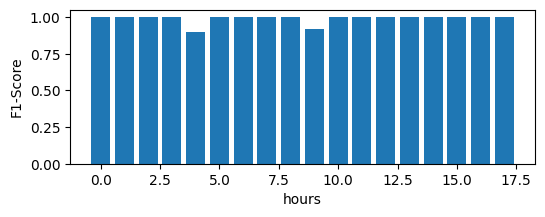

In [14]:
display_all_hr_metrics(all_metrics)

In [15]:
all_metrics = all_hr_evaluate(conn_features, 5, conn_nfeatures, conn_tfeatures[0])
for i,x in enumerate(all_metrics):
    print(f'Post Training Hour:{i} Score: {x[0]:.2f} Wrong Ones: {x[1]}')

Post Training Hour:0 Score: 0.91 Wrong Ones: ['192.168.1.120 true Triby predicted Samsung']
Post Training Hour:1 Score: 1.00 Wrong Ones: []
Post Training Hour:2 Score: 1.00 Wrong Ones: []
Post Training Hour:3 Score: 0.90 Wrong Ones: ['192.168.1.196 true Samsung predicted TP-Link']
Post Training Hour:4 Score: 0.91 Wrong Ones: ['192.168.1.168 true Google predicted TP-Link']
Post Training Hour:5 Score: 1.00 Wrong Ones: []
Post Training Hour:6 Score: 1.00 Wrong Ones: []
Post Training Hour:7 Score: 0.91 Wrong Ones: ['192.168.1.196 true Samsung predicted TP-Link']
Post Training Hour:8 Score: 1.00 Wrong Ones: []
Post Training Hour:9 Score: 1.00 Wrong Ones: []
Post Training Hour:10 Score: 1.00 Wrong Ones: []
Post Training Hour:11 Score: 1.00 Wrong Ones: []
Post Training Hour:12 Score: 0.91 Wrong Ones: ['192.168.1.120 true Triby predicted TP-Link']
Post Training Hour:13 Score: 1.00 Wrong Ones: []
Post Training Hour:14 Score: 1.00 Wrong Ones: []
Post Training Hour:15 Score: 1.00 Wrong Ones: []
P

In [16]:
all_metrics = all_hr_evaluate(http_features, 5, http_nfeatures, http_tfeatures[0])
for i,x in enumerate(all_metrics):
    print(f'Post Training Hour:{i} Score: {x[0]:.2f} Wrong Ones: {x[1]}')

Post Training Hour:0 Score: 1.00 Wrong Ones: []
Post Training Hour:1 Score: 0.75 Wrong Ones: ['192.168.1.177 true PixStar predicted TP-Link']
Post Training Hour:2 Score: 1.00 Wrong Ones: []
Post Training Hour:3 Score: 0.67 Wrong Ones: ['192.168.1.249 true Samsung predicted TP-Link']
Post Training Hour:4 Score: 1.00 Wrong Ones: []
Post Training Hour:5 Score: 0.67 Wrong Ones: ['192.168.1.239 true Samsung predicted TP-Link']
Post Training Hour:6 Score: 1.00 Wrong Ones: []
Post Training Hour:7 Score: 1.00 Wrong Ones: []
Post Training Hour:8 Score: 1.00 Wrong Ones: []
Post Training Hour:9 Score: 1.00 Wrong Ones: []
Post Training Hour:10 Score: 0.67 Wrong Ones: ['192.168.1.249 true Samsung predicted TP-Link']
Post Training Hour:11 Score: 0.75 Wrong Ones: ['192.168.1.241 true Netatmo predicted TP-Link']
Post Training Hour:12 Score: 0.75 Wrong Ones: ['192.168.1.120 true Triby predicted TP-Link']
Post Training Hour:13 Score: 0.75 Wrong Ones: ['192.168.1.239 true Samsung predicted TP-Link']
Post

In [17]:
# We notice that DNS based identification works much better than connections or http based identification. 
# This is surprising since the data samples are smaller for DNS queries than connections and http. 

print(conn_df.shape) 
print(http_df.shape)
print(dns_df.shape)

(20469, 22)
(5515, 25)
(4117, 26)
